# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install ipynb
import sys
sys.path.insert(0,'/content/drive/MyDrive/CNN-deterministic-decoupling')
path = '/content/drive/MyDrive/CNN-deterministic-decoupling'
from ipynb.fs.defs.imageFunctions import show_image,save_image
from ipynb.fs.defs.DISTS_mod import DISTS
import os
import torch
import math
import time
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
!pip install torchdiffeq
from torchdiffeq import odeint  # ODE solver: https://github.com/rtqichen/torchdiffeq
from torchvision.transforms import transforms
from torchvision import models
from torchvision.models import VGG16_Weights

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Hacia_Atras_Runge-Kutta

In [ ]:
def plot_history(history, title='', save=False):
    fig, ax = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle(title, fontsize=16)

    x0 = transforms.ToPILImage()(history['x0'].squeeze(0))
    xf = transforms.ToPILImage()(history['x'].squeeze(0))
    ref = transforms.ToPILImage()(history['ref'].squeeze(0))

    ax[0, 0].imshow(x0)
    ax[0, 0].set_title('start')
    ax[0, 1].imshow(xf)
    ax[0, 1].set_title('end')
    ax[0, 2].imshow(ref)
    ax[0, 2].set_title('reference')
    ax[1, 0].plot(range(1, len(history['loss']) + 1), history['loss'])
    ax[1, 0].set_xlabel('Iterations')
    ax[1, 0].set_ylabel('Loss')
    ax[1, 0].set_title(f'training loss (last: {history["loss"][-1]:.6f})')
    ax[1, 1].plot(range(1, len(history['error']) + 1), history['error'])
    ax[1, 1].set_xlabel('Iterations')
    ax[1, 1].set_ylabel('Error')
    ax[1, 1].set_title(f'training error (last: {history["error"][-1]:.6f})')
    ax[1, 2].plot(history['loss'], history['error'])
    ax[1, 2].set_xlabel('loss')
    ax[1, 2].set_ylabel('Error')
    ax[1, 2].set_title('error vs. loss')

    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig(f'history_{title}.png')
    plt.close()


def train(_x, _t, _model, _train_params, max_iters=1e6, log_interval=100, plt_interval=0):
    stop_loss = False
    stop_loss_value = 0
    patience = 0
    best_error = math.inf
    best_iter = 0
    x_0 = _x.detach().clone()
    err_ref = _train_params['error_reference']

    if _train_params['stop_condition'] == 'loss':
        stop_loss_value = _train_params['stop_loss']
        stop_loss = True
    elif _train_params['stop_condition'] == 'best':
        patience = _train_params['patience']

    # show_image(_x, f'it: {0}')
    count = 0
    elapsed_time = 0
    errors = []
    losses = []
    history = {}
    ts = time.perf_counter()
    while count < max_iters:
        _x = odeint(func=_model.grad, y0=_x, t=_t)[1]
        loss = model.forward(_x).item()
        error = math.sqrt(((err_ref - _x) ** 2).mean()) / math.sqrt((err_ref ** 2).mean())
        errors.append(error)
        losses.append(loss)
        count += 1

        if count % log_interval == 0:
            delta_t = time.perf_counter() - ts
            elapsed_time += delta_t
            ts = time.perf_counter()
            print(f'it: {count:6d} ({delta_t:05.2f}s)| loss: {losses[-1]:.8f} | error: {errors[-1]:.8f}')

        if plt_interval > 0 and count % plt_interval == 0:
            show_image(_x, f'it: {count:6d} | loss: {losses[-1]:.8f} | error: {errors[-1]:.8f}')

        if errors[-1] < best_error:
            best_error = errors[-1]
            best_iter = count

        if stop_loss and loss < stop_loss_value:
            print(f'Stopping condition reached: loss < {stop_loss_value}')
            print(f'it: {count:6d} ({elapsed_time:.2f}s)| loss: {losses[-1]:.8f} | error: {errors[-1]:.8f}\n')
            break

        if not stop_loss and count - best_iter > patience:
            print(f'Stopping condition reached: best error not improved in {patience} iterations')
            print(f'it: {count:6d} ({elapsed_time:.2f}s)| loss: {losses[-1]:.8f} | error: {errors[-1]:.8f}\n')
            break

        if count%2000==0:
          with open(path+'/Datos/RK45_data_001.txt', 'w') as f:
            f.write(f'Total iterations: {count}\n')
            f.write('\n')
            f.write(f'Error values: {errors}\n')
            f.write('\n')
            f.write(f'Loss values: {losses}\n')
            f.close()

          save_image(_x,path+'/Datos/current_RK45_001.png')

    history['x'] = _x.detach().clone()
    history['x0'] = x_0
    history['ref'] = _model.ref.detach().clone()
    history['loss'] = losses
    history['error'] = errors


    return history


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 126MB/s]


it:    100 (34.63s)| loss: 1.46776092 | error: 0.02577887
it:    200 (24.66s)| loss: 1.23066545 | error: 0.03663673
it:    300 (17.49s)| loss: 1.09305012 | error: 0.04493337
it:    400 (12.41s)| loss: 0.99850863 | error: 0.05179998
it:    500 (12.62s)| loss: 0.92629415 | error: 0.05778703
it:    600 (12.64s)| loss: 0.86765271 | error: 0.06316158
it:    700 (11.27s)| loss: 0.81818640 | error: 0.06807676
it:    800 (10.12s)| loss: 0.77508759 | error: 0.07265131
it:    900 (10.36s)| loss: 0.73669326 | error: 0.07695019
it:   1000 (10.85s)| loss: 0.70227778 | error: 0.08100459
it:   1100 (11.19s)| loss: 0.67115903 | error: 0.08484439
it:   1200 (10.61s)| loss: 0.64281517 | error: 0.08848601
it:   1300 (10.03s)| loss: 0.61701852 | error: 0.09194924
it:   1400 (10.16s)| loss: 0.59327501 | error: 0.09527135
it:   1500 (10.15s)| loss: 0.57133067 | error: 0.09845789
it:   1600 (10.10s)| loss: 0.55109310 | error: 0.10150918
it:   1700 (10.02s)| loss: 0.53238714 | error: 0.10443684
it:   1800 (10

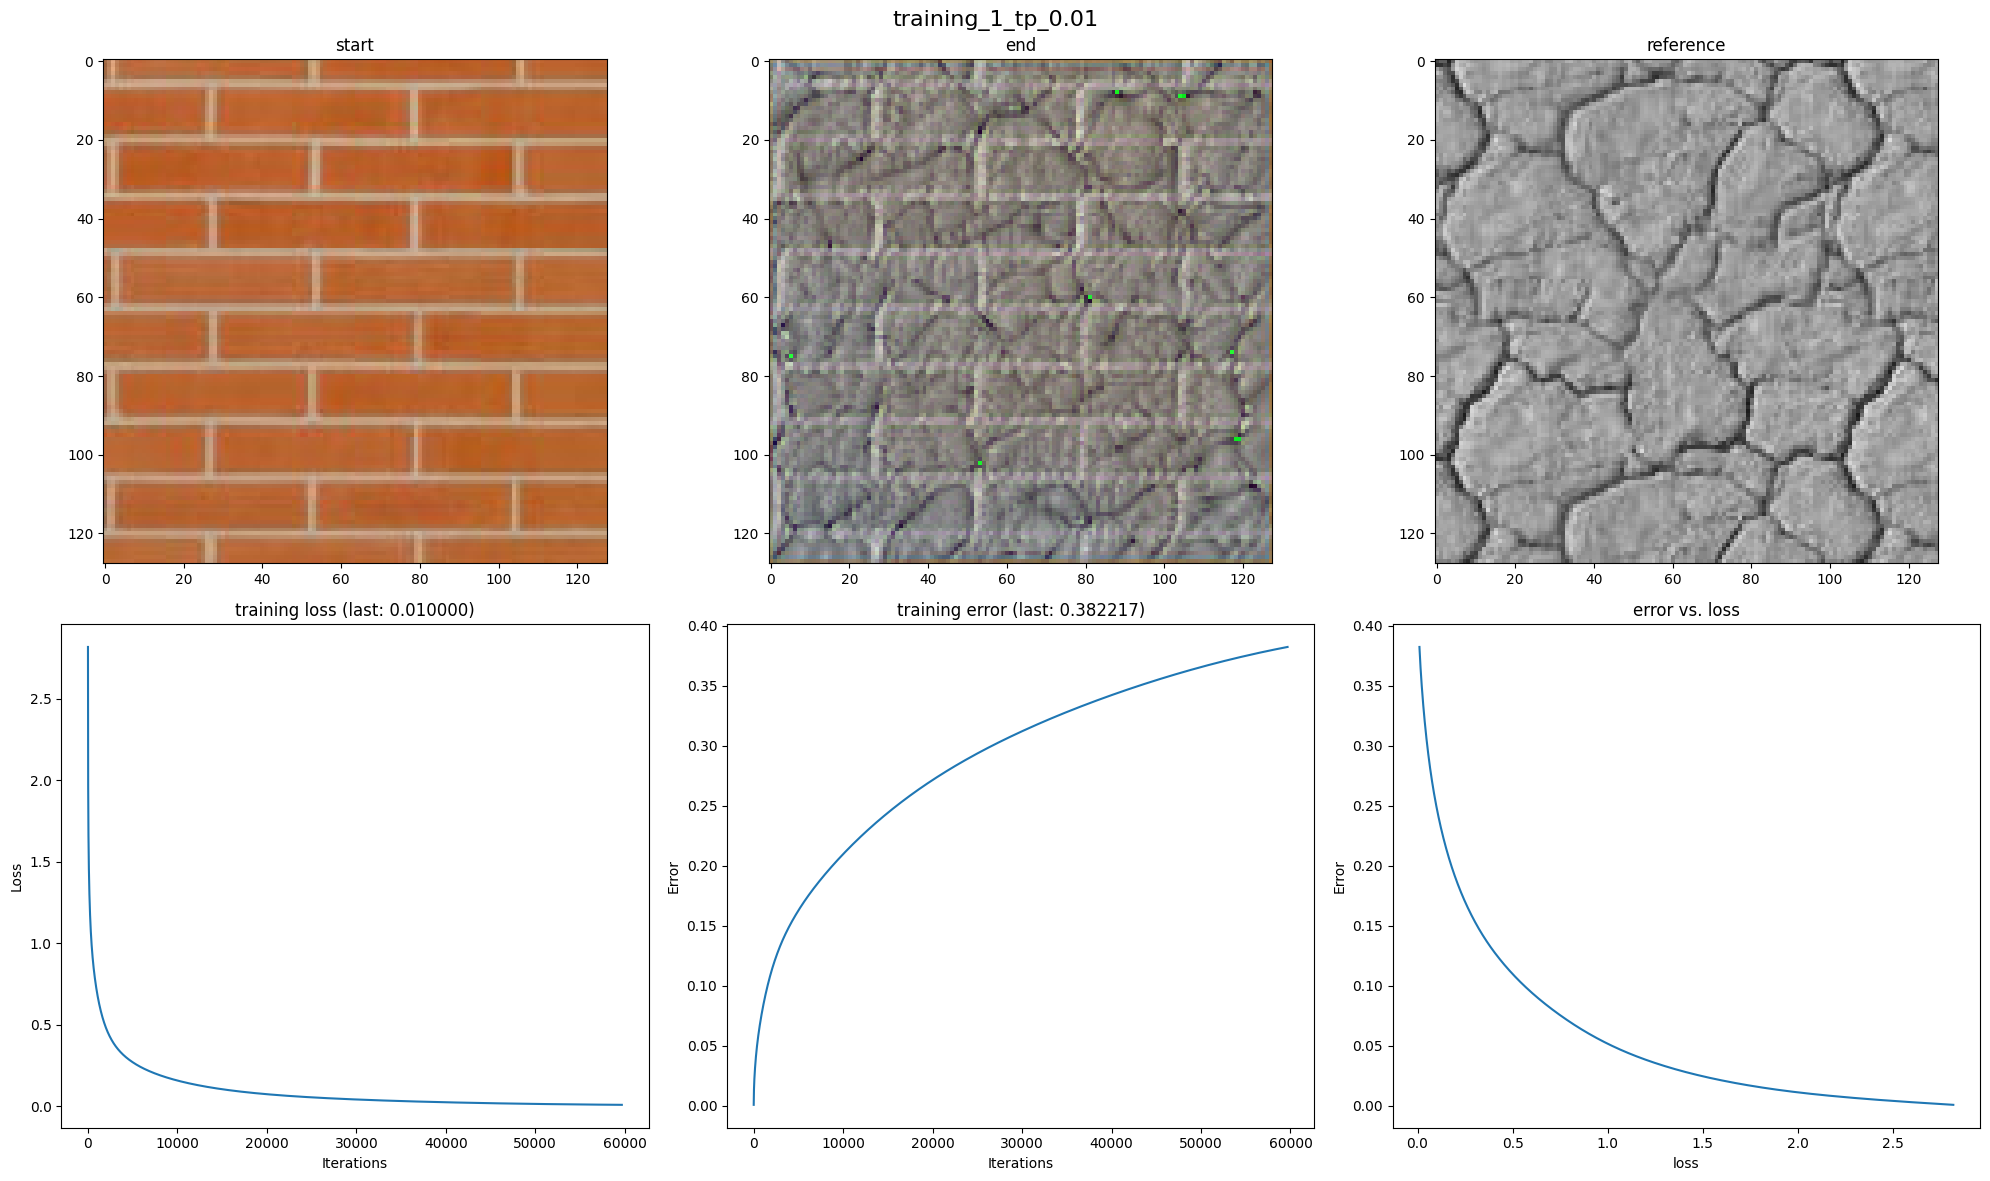

it:    100 (27.70s)| loss: 0.74462616 | error: 0.38047058
it:    200 (10.17s)| loss: 0.67527300 | error: 0.37895304
it:    300 (10.13s)| loss: 0.62349689 | error: 0.37755775
it:    400 (09.97s)| loss: 0.58165389 | error: 0.37625381
it:    500 (10.21s)| loss: 0.54648238 | error: 0.37502392
it:    600 (10.16s)| loss: 0.51625526 | error: 0.37384853
it:    700 (10.15s)| loss: 0.48966017 | error: 0.37272639
it:    800 (09.99s)| loss: 0.46600437 | error: 0.37164572
it:    900 (10.21s)| loss: 0.44473958 | error: 0.37060277
it:   1000 (10.16s)| loss: 0.42557475 | error: 0.36959185
it:   1100 (10.19s)| loss: 0.40833598 | error: 0.36861163
it:   1200 (09.92s)| loss: 0.39270553 | error: 0.36765997
it:   1300 (10.16s)| loss: 0.37846276 | error: 0.36673224
it:   1400 (10.22s)| loss: 0.36537775 | error: 0.36582642
it:   1500 (10.17s)| loss: 0.35330370 | error: 0.36493938
it:   1600 (09.93s)| loss: 0.34211007 | error: 0.36407101
it:   1700 (10.15s)| loss: 0.33172044 | error: 0.36321943
it:   1800 (10

In [ ]:
if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    ref_0 = Image.open(os.path.join(path,path+"/imagenes/texture5.jpg")).convert('RGB').crop((0, 0, 128, 128))
    ref_0 = transforms.ToTensor()(ref_0).unsqueeze(0).to(device)
    ref_0.requires_grad_(False)
    x = Image.open(os.path.join(path, path+'/imagenes/texture4.jpg')).convert('RGB').crop((0, 0, 128, 128))
    x = transforms.ToTensor()(x).unsqueeze(0).to(device)
    ref_1 = x.detach().clone().to(device)

    model = DISTS().to(device)

    turning_point_loss = 0.01
    t = torch.tensor([0, -0.1]).to(device)
    model.set_target(ref_0)
    train_params = {'stop_condition': 'loss', 'stop_loss': turning_point_loss, 'error_reference': ref_1}
    history_1 = train(_x=x, _t=t, _model=model, _train_params=train_params, max_iters=5e5, log_interval=100)
    plot_history(history_1, title=f'training_1_tp_{turning_point_loss}', save=True)

    t = torch.tensor([0, -0.1]).to(device)
    model.set_target(ref_1)
    x = history_1['x'].detach().clone()
    save_image(x,path+'/Datos/turning_RK45_001.png')
    train_params = {'stop_condition': 'best', 'patience': 1, 'error_reference': ref_1}
    history_2 = train(_x=x, _t=t, _model=model, _train_params=train_params, max_iters=5e5, log_interval=100)
    plot_history(history_2, title=f'training_2_tp_{turning_point_loss}', save=True)